# Introduction

The purpose of this project is to predict the probability that an online transaction is fraudulent. 

# Data discription

The data is broken into two files identity and transaction.

**Transaction**

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)  
TransactionAMT: transaction payment amount in USD  
ProductCD: product code, the product for each transaction  
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.  
addr: address  
dist: distance  
P_ and (R__) emaildomain: purchaser and recipient email domain  
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.  
D1-D15: timedelta, such as days between previous transaction, etc.  
M1-M9: match, such as names on card and address, etc.  
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.  


Categorical Features:  
ProductCD  
card1 - card6  
addr1, addr2  
Pemaildomain Remaildomain  
M1 - M9  

**Identity**

* Categorical Features:  
DeviceType  
DeviceInfo  
id_12 - id_38  

There are total 144,233 instances and 434 features. The corresponding class variable indicates fraudulent. The data is highly imbalanced. There are 92.15% instances of non-fraudulent and 7.84% instances of fraudulent.

# Data loading and overview

In [1]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from chart_studio import tools
import chart_studio.plotly as py
tools.set_credentials_file(username='xian.c', api_key='lPQcQ2KGyGxEN8Gd7jb8')

from scipy import stats
from scipy.stats import chisquare
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
import numpy.ma as ma

from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier
import xgboost as xgb
# import lightgbm as lgb

In [2]:
train_identity = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/train_identity.csv')

In [3]:
train_transaction = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/train_transaction.csv')

In [4]:
test_transaction = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/test_transaction.csv')

In [5]:
test_identity = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/test_identity.csv')

In [6]:
# split data into training and test set
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction,test_identity, on = 'TransactionID', how = 'left')

In [7]:
print('train:',train.shape)
print('test:', test.shape)

train: (590540, 434)
test: (506691, 433)


In [8]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [17]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [18]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [19]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  id-31  id-32  id-33  id-34 id-35  \
0  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
1  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
2  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
3  150.0        visa  166.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
4  150.0  mastercard  117.0  debit  ...    NaN    NaN    NaN    NaN   NaN   

  id-36  id-37  id-38  DeviceType  DeviceInfo  
0   NaN    NaN    NaN         NaN         NaN  
1   NaN    NaN    NaN         NaN         NaN  
2   NaN    NaN    NaN         NaN         NaN  
3   NaN    NaN    NaN         NaN         NaN  
4   NaN    NaN    NaN         NaN         NaN  

[5 rows x 433 columns]

In [9]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [10]:
test.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [11]:
print(list(test.columns).index("id-01"))
print(list(test.columns).index("id-38"))

393
430


In [8]:
test.columns = list(test.columns)[0:393]+['id_0'+str(i) for i in range(1,10)]+['id_'+str(i) for i in range(10,39)]+list(test.columns)[431:]

In [9]:
del train_transaction, train_identity, test_transaction, test_identity

# EDA

In [393]:
f = train.loc[train['isFraud']==1,:]
nf = train.loc[train['isFraud']==0,:]

## Target variable

In [155]:
c = Counter(train['isFraud'])
c

Counter({0: 569877, 1: 20663})

In [82]:
layout = go.Layout(
    title=go.layout.Title(
        text='Class distribution'
    ),

    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of instances')))

fig = go.Figure(data=[go.Bar(
            x=['Non-fraud','Fraud'], y=list(c.values()),
            text=[str(round(i,2))+'%' for i in np.array(list(c.values()))/sum(c.values())*100],
            textposition='auto',
        )],layout=layout)


fig.show()

The data is highly imbalanced.

## TransactionDT

In [14]:
train['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int64

Text(0.5, 1.0, 'Train vs Test TransactionDT Distribution')

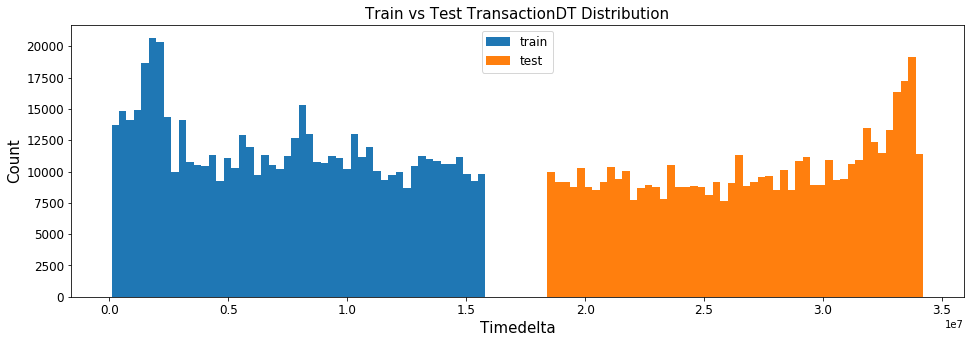

In [15]:
train['TransactionDT'].plot(kind = 'hist',
                            label = 'train',figsize=(16, 5),bins=50,
                            fontsize=12)
test['TransactionDT'].plot(kind = 'hist',bins=50,label = 'test')

plt.legend(fontsize=12)
plt.show
plt.ylabel("Count",fontsize=15)
plt.xlabel("Timedelta",fontsize=15)

plt.title('Train vs Test TransactionDT Distribution',fontsize=15)

TransactionDT: timedelta from a given reference datetime (not an actual timestamp). 

From the above plot, we can see that the training and test set seems to be split by time.

In [16]:
print('train: max = {}, min = {}'.format
      (max(train['TransactionDT']), min(train['TransactionDT'])))
      

train: max = 15811131, min = 86400


In [17]:
print('test: max = {}, min = {}'.format
      (max(test['TransactionDT']), min(test['TransactionDT'])))
      

test: max = 34214345, min = 18403224


 The timespan of the data set is the different between ```train.min()``` and ```test.max()```, which is ```34214345 - 86400 = 34127945``` but we dont know whether it is in seconds, minutes or hours.

In [19]:
34127945/(3600*24*365)

1.0821900367833588

 If it is in seconds, the timespan will be 1 year which is reasonable.

In [20]:
d = (max(train['TransactionDT'])-min(train['TransactionDT']))/(3600*24)
d2 = (max(test['TransactionDT'])-min(test['TransactionDT']))/(3600*24)
d1 = (min(test['TransactionDT'])-max(train['TransactionDT']))/(3600*24)

print('Timespan of the total data set is {} days'.format(d+d2))
print('Timespan of the training set is {} days'.format(d))
print('Timespan of the test set is {} days'.format(d2))
print('The gap between the training and test set is {} days'.format(d1))


Timespan of the total data set is 364.998287037037 days
Timespan of the training set is 181.99920138888888 days
Timespan of the test set is 182.99908564814814 days
The gap between the training and test set is 30.00107638888889 days


## TransactionAmt

In [39]:
100*train['TransactionAmt'].isna().sum()

0

**Transaction Amounts Quantiles**

In [ ]:
print("training set: Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

print("test set: Transaction Amounts Quantiles:")
print(test['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

**Transaction Amount Distribution Plot**

Text(0.5, 1.0, 'Transaction Amount Distribution by class (99%)')

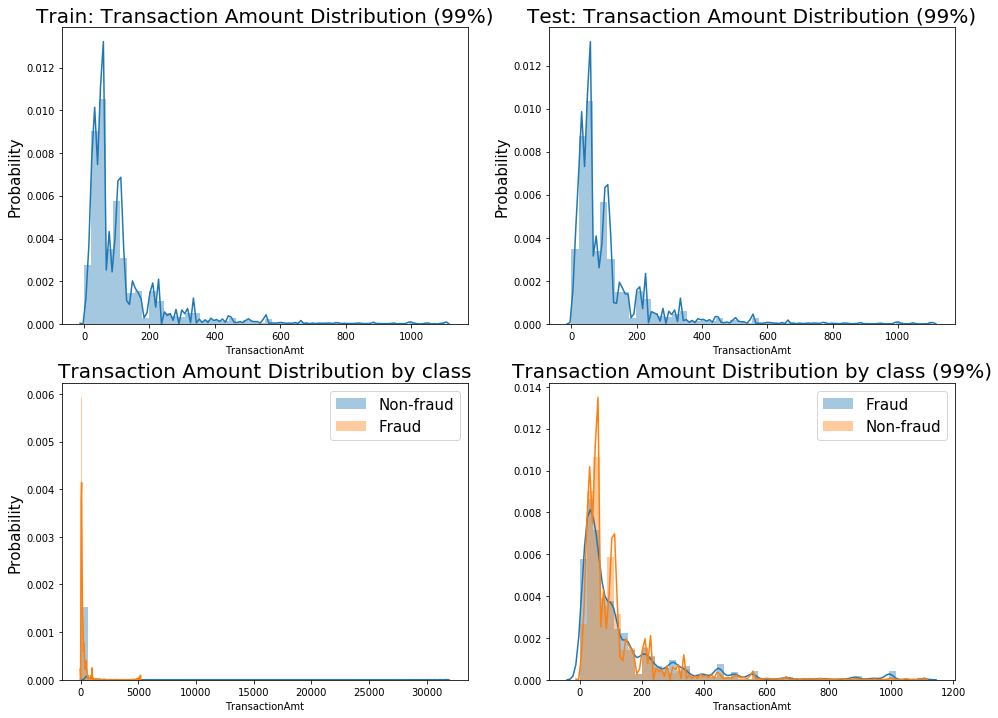

In [134]:
plt.figure(figsize=(16,12))

plt.subplot(221)
sns.distplot(train.loc[train['TransactionAmt']<= 1104,'TransactionAmt'])
plt.title('Train: Transaction Amount Distribution (99%)',fontsize=20)
plt.ylabel("Probability",fontsize=15)

plt.subplot(222)
sns.distplot(test.loc[test['TransactionAmt']<= 1104,'TransactionAmt'])
plt.title('Test: Transaction Amount Distribution (99%)',fontsize=20)
plt.ylabel("Probability",fontsize=15)


plt.subplot(223)
sns.distplot(nf.loc[:,'TransactionAmt'],label='Non-fraud')
sns.distplot(f.loc[:,'TransactionAmt'],label='Fraud')
plt.legend(fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.title('Transaction Amount Distribution by class',fontsize=20)

plt.subplot(224)
sns.distplot(f.loc[f['TransactionAmt']<= 1104,'TransactionAmt'],label='Fraud')
sns.distplot(nf.loc[nf['TransactionAmt']<= 1104,'TransactionAmt'],label='Non-fraud')
plt.legend(fontsize=15)
plt.title('Transaction Amount Distribution by class (99%)',fontsize=20)

## ProductCD (cat)

In [38]:
100*train['ProductCD'].isna().sum()

0

In [119]:
fp = Counter(f['ProductCD'])
nfp = Counter(nf['ProductCD'])
top = Counter(train['ProductCD'])

d = np.array(list(nfp.values()))/np.array(list(top.values()))*100
d = [round(100-i,2) for i in d ]

In [ ]:
tamt = f.groupby('ProductCD')['TransactionAmt'].sum()
tolamt = train.groupby('ProductCD')['TransactionAmt'].sum()
amt_per = tamt/tolamt*100

In [192]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]],
                    subplot_titles=('Number of transactions by product type','Transaction amount by product type'))

fig.add_trace(go.Bar(name='No Fraud', x=list(nfp.keys()), y=list(nfp.values())),secondary_y=False,row=1, col=1)
fig.add_trace(go.Bar(name='Fraud', x=list(fp.keys()), y=list(fp.values())),row=1, col=1,secondary_y=False)
fig.add_trace(go.Scatter(name = '% Fraud Transactions', x=list(top.keys()), y=d),row=1, col=1,
    secondary_y=True)

fig.add_trace(go.Bar(name='Fraud Amount', x=list(tamt.index.values), y=list(tamt.values)),row=1, col=2,secondary_y=False)
fig.add_trace(go.Scatter(name = '% Fraud Transaction Amount', x=list(amt_per.index.values), y=list(amt_per.values)),row=1, col=2,
    secondary_y=True)


fig.update_xaxes(title_text='product code')
fig.update_yaxes(title_text='Count', secondary_y=False)
fig.update_yaxes(title_text="Percentage", secondary_y=True)
fig['layout']['yaxis3'].update(title='Amount')
fig['layout']['yaxis4'].update(title='Percentage')

fig.show()

* Yellow line: The total amount of false transactions as a percentage of the total amount of transactions by product type
* Green line: The total number of false transactions as a percentage of the total number of transactions

 
We can see that product C has the highest percentage of fraudulent transactions, which means transactions about product C is more likely to be fraudulent. Product H has more fraudulent transactions than product R but the fraudulent amount of product R is highter than product H, meaning that product R is more expensive than product H.

## D1 - D15

D columns: timedelta, such as days between previous transaction, etc

In [8]:
Dcol = ['D'+str(i) for i in range(1,16)]
train[Dcol].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

In [41]:
train['D15'].value_counts()

 0.0      174246
 1.0        5936
 2.0        3691
 3.0        2878
 7.0        2577
           ...  
 851.0         1
 850.0         1
-15.0          1
 849.0         1
-28.0          1
Name: D15, Length: 859, dtype: int64

### Missing values

In [10]:
pd.DataFrame(100*train[['D'+str(i) for i in range(1,16)]].isna().sum()/train.shape[0]).sort_values(by = 0)


0
D1    0.214888
D10  12.873302
D15  15.090087
D4   28.604667
D3   44.514851
D11  47.293494
D2   47.549192
D5   52.467403
D8   87.312290
D9   87.312290
D6   87.606767
D12  89.041047
D14  89.469469
D13  89.509263
D7   93.409930

Only D1, D10, D15, D4 has fewer missing values.

### Correlation

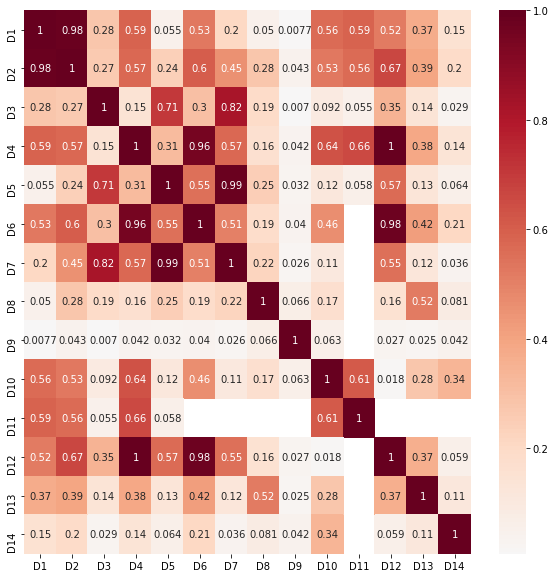

In [282]:
plt.figure(figsize=(10,10))
sns.heatmap(train[Dcol].corr(),cmap='RdBu_r',center=0.0,annot=True)

### Histogram Plot

In [115]:
# function to make hist subplots
# input list of colunms names
def sub_plots(cols):
    col = 3
    row = len(cols)//3+1
    plt.figure(figsize=(19,row*5))
    
    for i,v in enumerate(cols):  
        plt.subplot(row, col, i+1)       
        # 99.9% of data
        sns.distplot(train[v][train[v]<=train[v].quantile(.999)], kde=False, rug=False, label = 'train (99.9%)')
        sns.distplot(test[v][test[v]<=test[v].quantile(.999)], kde=False, rug=False, label = 'train (99.9%)')
        plt.legend()
    
    plt.show()

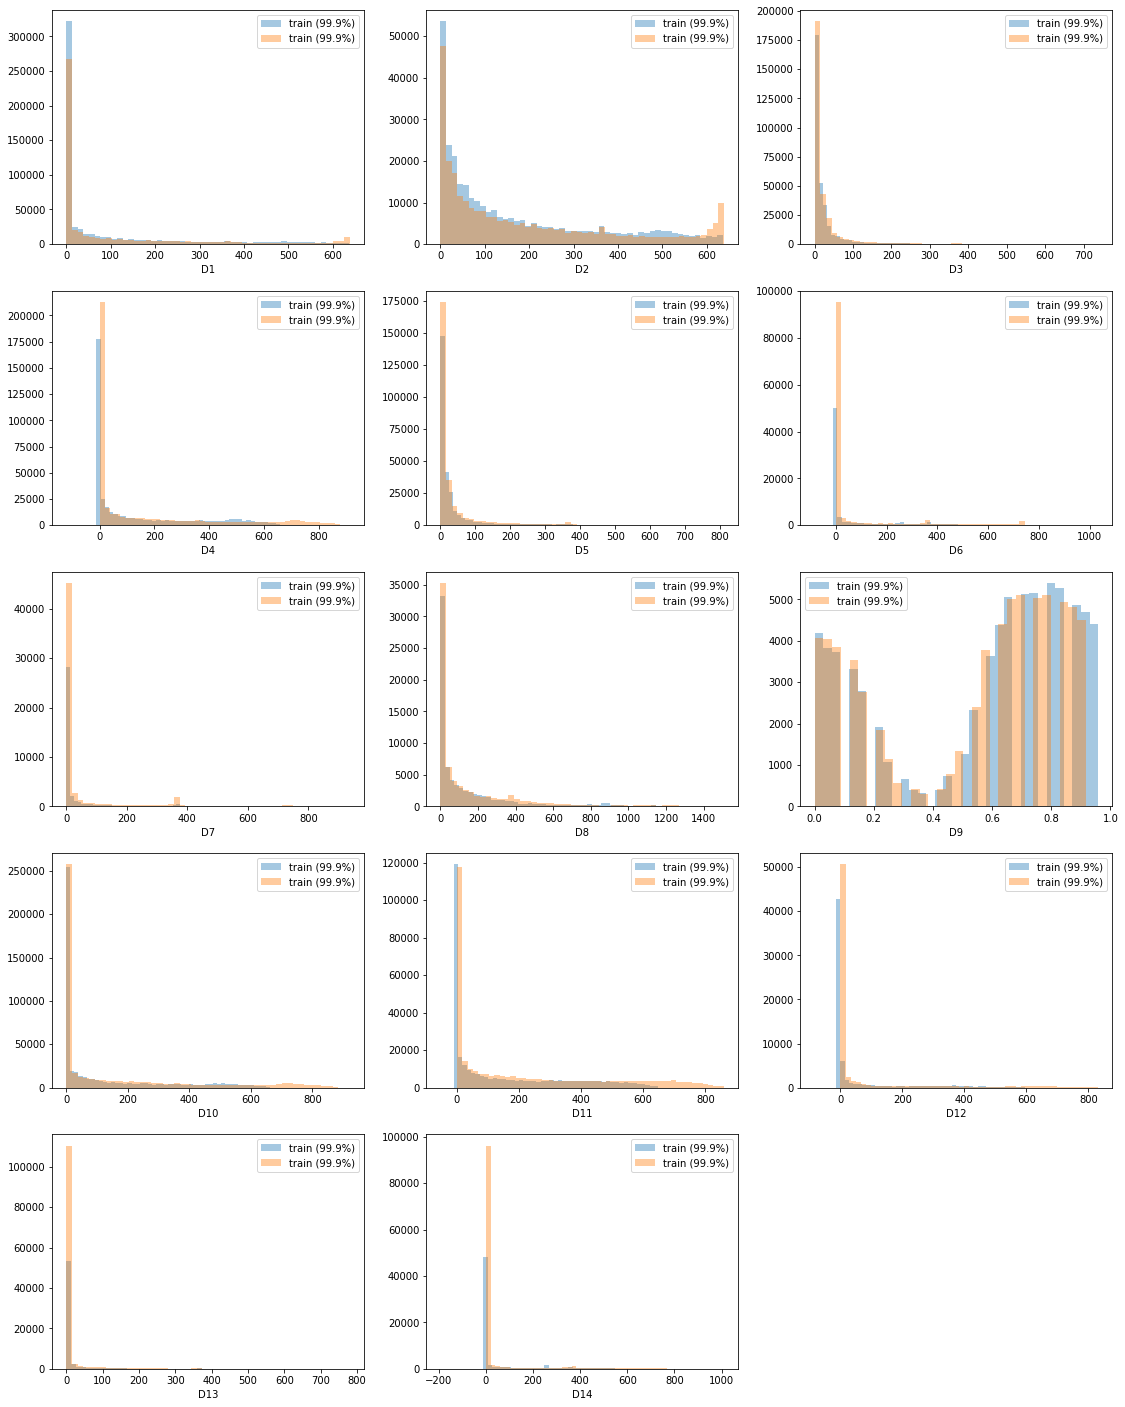

In [347]:
sub_plots(Dcol)

### D1

<function matplotlib.pyplot.show(*args, **kw)>

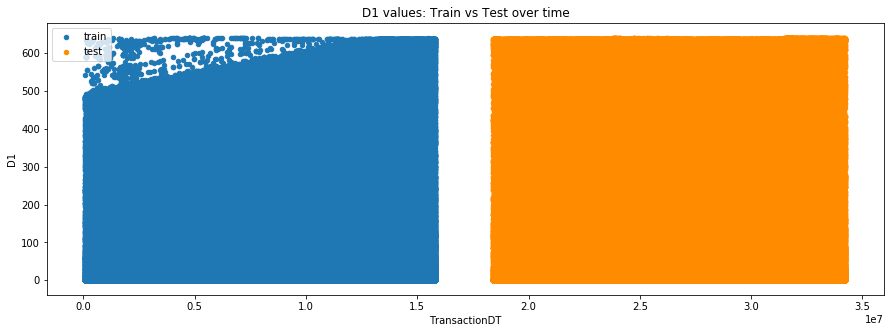

In [240]:
d1 = train[['D1','TransactionDT']]
d2 = test[['D1','TransactionDT']]

ax = d1.plot(kind = 'scatter',x ='TransactionDT' ,y='D1',label = 'train',figsize=(15, 5),
                            title = 'D1 values: Train vs Test over time')
d2.plot(kind = 'scatter',x ='TransactionDT' ,y='D1',label = 'test',ax=ax,color='darkorange')
plt.ylabel('')

plt.legend()
plt.show

Text(0.5, 1.0, 'D1 Distribution (test)')

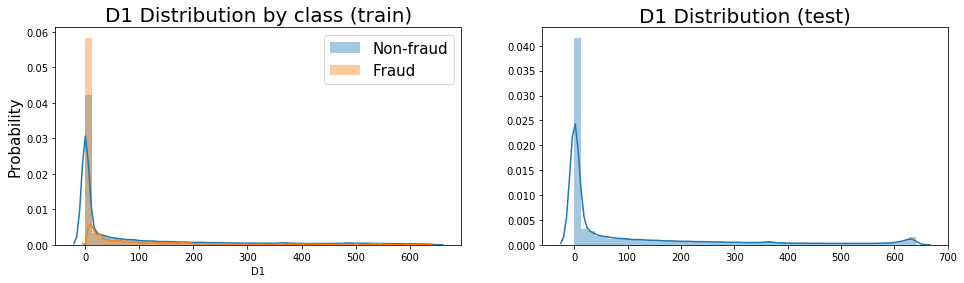

In [179]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot(nf.loc[:,'D1'],label='Non-fraud')
sns.distplot(f.loc[:,'D1'],label='Fraud')
plt.legend(fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.title('D1 Distribution by class (train)',fontsize=20)

plt.subplot(122)
sns.distplot(test[['D1']])
plt.title('D1 Distribution (test)',fontsize=20)

The distribution between the training set and the test set is similar.

### D4


<function matplotlib.pyplot.show(*args, **kw)>

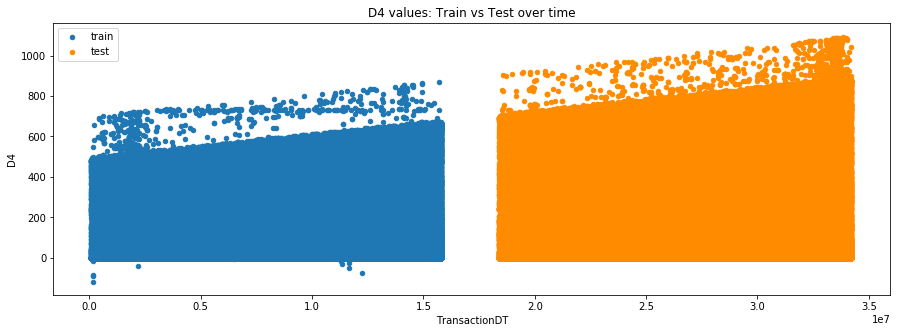

In [135]:
d1 = train[['D4','TransactionDT']]
d2 = test[['D4','TransactionDT']]

ax = d1.plot(kind = 'scatter',x ='TransactionDT' ,y='D4',label = 'train',figsize=(15, 5),
                            title = 'D4 values: Train vs Test over time')
d2.plot(kind = 'scatter',x ='TransactionDT' ,y='D4',label = 'test',ax=ax,color='darkorange')
plt.ylabel('')
plt.legend()
plt.show

Text(0.5, 1.0, 'D4 Distribution (test)')

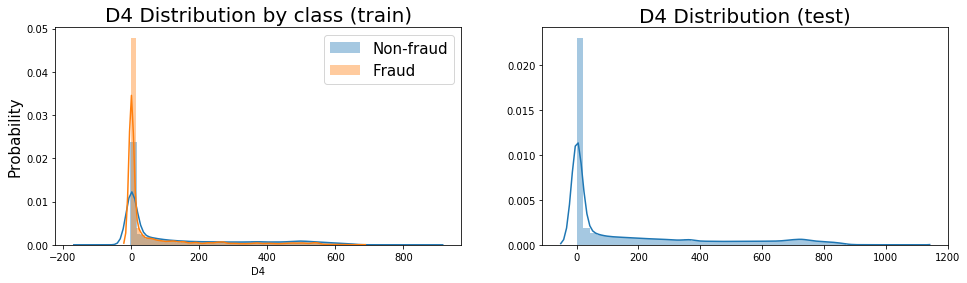

In [180]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot(nf.loc[:,'D4'],label='Non-fraud')
sns.distplot(f.loc[:,'D4'],label='Fraud')
plt.legend(fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.title('D4 Distribution by class (train)',fontsize=20)

plt.subplot(122)
sns.distplot(test[['D4']])
plt.title('D4 Distribution (test)',fontsize=20)

The distribution of D4 is quite different between these two classes.
The distribution between the training set and the test set is similar.

### D10

<function matplotlib.pyplot.show(*args, **kw)>

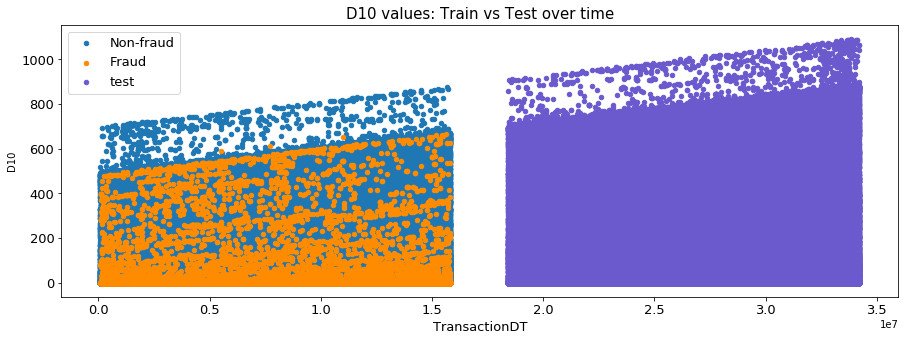

In [206]:
d1 = train[['D10','TransactionDT','isFraud']]
d2 = test[['D10','TransactionDT']]

ax=d1.loc[d1['isFraud']==0,:].plot(kind = 'scatter',x ='TransactionDT' ,y='D10',label = 'Non-fraud',figsize=(15, 5),fontsize=15)
ax2=d1.loc[d1['isFraud']==1,:].plot(kind = 'scatter',x ='TransactionDT' ,y='D10',label = 'Fraud',figsize=(15, 5)
                            ,ax=ax,color='darkorange',fontsize=13)
ax3=d2.plot(kind = 'scatter',x ='TransactionDT' ,y='D10',label = 'test',ax=ax,color='green',fontsize=13)
plt.legend(fontsize=13)
plt.xlabel('TransactionDT',fontsize=13)
plt.ylabel('')

plt.title('D10 values: Train vs Test over time',fontsize=15)
plt.show

Text(0.5, 1.0, 'D10 Distribution (test)')

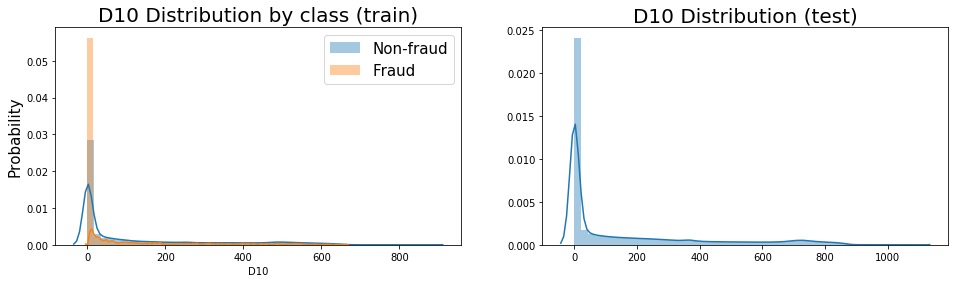

In [181]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot(nf.loc[:,'D10'],label='Non-fraud')
sns.distplot(f.loc[:,'D10'],label='Fraud')
plt.legend(fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.title('D10 Distribution by class (train)',fontsize=20)

plt.subplot(122)
sns.distplot(test[['D10']])
plt.title('D10 Distribution (test)',fontsize=20)

## card1 - card6 (cat)

In [383]:
col = ['card'+str(i) for i in range(1,7)]
train[col].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

### Missing values

In [384]:
100*train[['card'+str(i) for i in range(1,7)]].isna().sum()/train.shape[0]

card1    0.000000
card2    1.512683
card3    0.265012
card4    0.267044
card5    0.721204
card6    0.266028
dtype: float64

### Correlation

In [386]:
train2 = train[['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud']].sample(frac = 0.2)

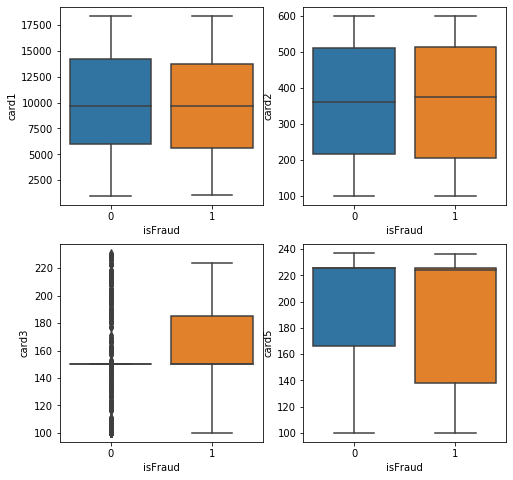

In [388]:
plt.figure(figsize=(8,8))

plt.subplot(221)
sns.boxplot(x="isFraud", y="card1", data=train2)
plt.subplot(222)
sns.boxplot(x="isFraud", y="card2", data=train2)
plt.subplot(223)
sns.boxplot(x="isFraud", y="card3", data=train2)
plt.subplot(224)
sns.boxplot(x="isFraud", y="card5", data=train2)

**Pearson correlation: card1,2,3,5**


<function matplotlib.pyplot.show(*args, **kw)>

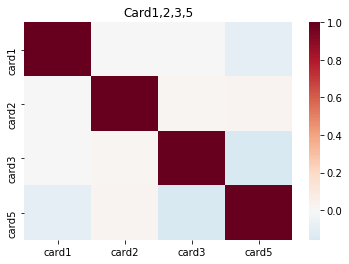

In [389]:
cor = train[['card1','card2','card3','card5']].corr()
sns.heatmap(cor, cmap = 'RdBu_r',annot=False, center=0.0)
plt.title('Card1,2,3,5')
plt.show

 **chi-square test: card4,card6**

A chi-square test for independence compares two categorical variables in a contingency table to see if they are related. 

In [229]:
con_table = pd.crosstab(train2['card4'], 
                        train2['card6'],  
                        margins = False) 
stats.chi2_contingency(con_table)

(126292.10359206528,
 0.0,
 16,
 array([[9.02580689e-01, 8.28055678e-03, 8.23722186e+01, 2.42692078e+02,
         2.48416703e-02],
        [4.48244827e+00, 4.11233786e-02, 4.09081663e+02, 1.20527140e+03,
         1.23370136e-01],
        [3.59094219e+00, 3.29444237e-02, 3.27720146e+02, 9.65557134e+02,
         9.88332712e-02],
        [1.04250838e+02, 9.56429708e-01, 9.51424393e+03, 2.80316795e+04,
         2.86928913e+00],
        [2.13773191e+02, 1.96122193e+00, 1.95095820e+04, 5.74807999e+04,
         5.88366580e+00]]))

Since the p value is 0.0 < 0.05, we reject the null hypothesis that there is no association between the two variables

### Histogram Plot

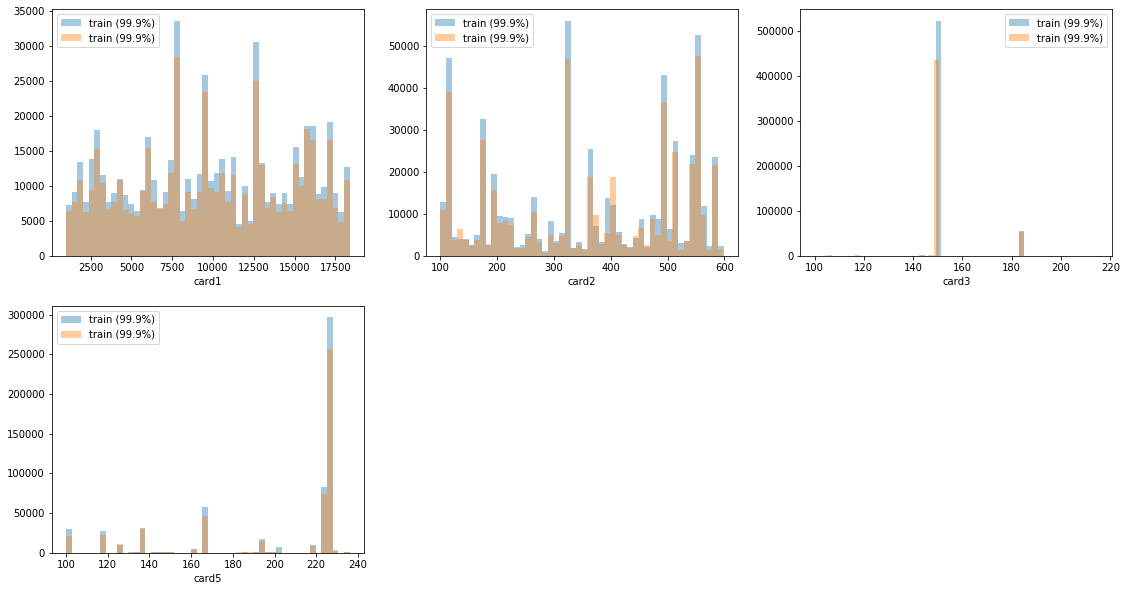

In [391]:
sub_plots(['card1','card2','card3','card5'])

### Density Plot 

Text(0.5, 1.0, 'Card1 Distribution plot by class (train)')

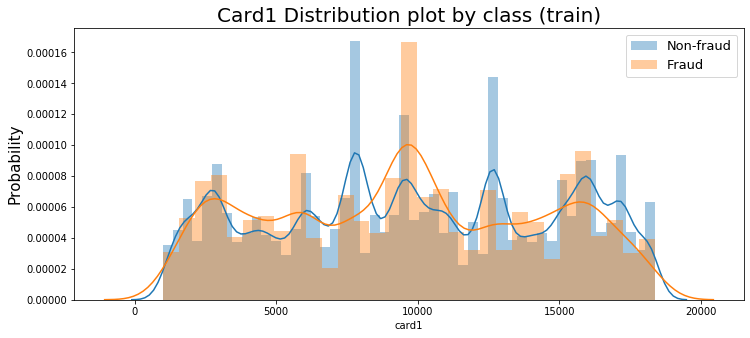

In [394]:
plt.figure(figsize=(12,5))

sns.distplot(nf.loc[:,'card1'],label='Non-fraud')
sns.distplot(f.loc[:,'card1'],label='Fraud')
plt.legend(fontsize=13)
plt.ylabel("Probability",fontsize=15)
plt.title('Card1 Distribution plot by class (train)',fontsize=20)

### Plot against time

<function matplotlib.pyplot.show(*args, **kw)>

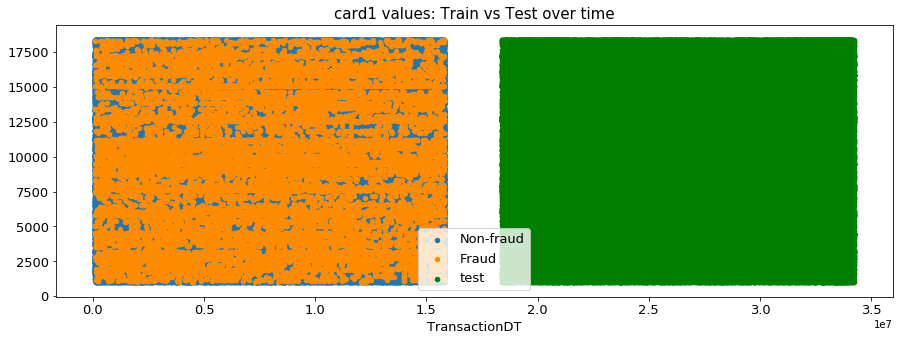

In [250]:
d1 = train[['card1','TransactionDT','isFraud']]
d2 = test[['card1','TransactionDT']]

ax=d1.loc[d1['isFraud']==0,:].plot(kind = 'scatter',x ='TransactionDT' ,y='card1',label = 'Non-fraud',figsize=(15, 5),fontsize=15)
ax2=d1.loc[d1['isFraud']==1,:].plot(kind = 'scatter',x ='TransactionDT' ,y='card1',label = 'Fraud',figsize=(15, 5)
                            ,ax=ax,color='darkorange',fontsize=13)
ax3=d2.plot(kind = 'scatter',x ='TransactionDT' ,y='card1',label = 'test',ax=ax,color='green',fontsize=13)
plt.legend(fontsize=13)
plt.xlabel('TransactionDT',fontsize=13)
plt.ylabel('')
plt.title('card1 values: Train vs Test over time',fontsize=15)
plt.show

### Uniqule Values

In [236]:
# unique value that only appears in training or test set
print('Card1')
train_val_count = train[col[0]].value_counts()
test_val_count = test[col[0]].value_counts()
uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))
print('# of unique values that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique values that only appears in the test set: {}.'.format(len(in_test_not_in_train)))


# of unique values in the training set: 13553
# of unique values in the test set: 13244
# of unique values that only appears in the training set: 3847.
# of unique values that only appears in the test set: 3538.


In [241]:
# unique value that only appears in training or test set
print('Card2')
train_val_count = train['card2'].value_counts()
test_val_count = test['card2'].value_counts()
uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))
print('# of unique values that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique values that only appears in the test set: {}.'.format(len(in_test_not_in_train)))


# of unique values in the training set: 500
# of unique values in the test set: 497
# of unique values that only appears in the training set: 4.
# of unique values that only appears in the test set: 1.


In [242]:
# unique value that only appears in training or test set
print('Card3')
train_val_count = train['card3'].value_counts()
test_val_count = test['card3'].value_counts()
uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))
print('# of unique values that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique values that only appears in the test set: {}.'.format(len(in_test_not_in_train)))


# of unique values in the training set: 114
# of unique values in the test set: 115
# of unique values that only appears in the training set: 18.
# of unique values that only appears in the test set: 19.


In [243]:
# unique value that only appears in training or test set
print('Card5')
train_val_count = train['card2'].value_counts()
test_val_count = test['card2'].value_counts()
uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))
print('# of unique values that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique values that only appears in the test set: {}.'.format(len(in_test_not_in_train)))



# of unique values in the training set: 500
# of unique values in the test set: 497
# of unique values that only appears in the training set: 4.
# of unique values that only appears in the test set: 1.


In [61]:
print('Card6')
train_val_count = train['card6'].value_counts()
test_val_count = test['card6'].value_counts()
print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

Card6
# of unique values in the training set: 4
# of unique values in the test set: 3


In [62]:
print('Card4')
train_val_count = train['card4'].value_counts()
test_val_count = test['card4'].value_counts()
print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

Card4
# of unique values in the training set: 4
# of unique values in the test set: 4


### card4 

In [35]:
fc = Counter(f['card4'])
nfc = Counter(nf['card4'])
to = Counter(train['card4'])
y = np.array(list(nfc.values()))/np.array(list(to.values()))*100

perc_amount = pd.DataFrame(f.groupby('card4')['TransactionAmt'].sum())/pd.DataFrame(train.groupby('card4')['TransactionAmt'].sum())*100
perc_amount = perc_amount['TransactionAmt']
dd = f.groupby('card4')['TransactionAmt'].sum()


In [36]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]],
                    subplot_titles=('Number of transactions by card company','Transaction amount by card company'))

fig.add_trace(go.Bar(name='No Fraud', x=list(nfc.keys()), y=list(nfc.values())),row=1, col=1,secondary_y=False) 
fig.add_trace(go.Bar(name='Fraud', x=list(fc.keys()), y=list(fc.values())),row=1, col=1,secondary_y=False)
fig.update_layout(barmode='group')
fig.add_trace(go.Scatter(name = '% Fraud Transactions', x=list(nfc.keys())[0:4], y= 100-y),row=1, col=1,
    secondary_y=True)


fig.add_trace(go.Bar(name='Fraud Amount', x=list(dd.index.values), y=list(dd.values)),row=1, col=2,secondary_y=False)
fig.add_trace(go.Scatter(name = '% Fraud Transactions Amount', x=list(perc_amount.index.values), y=list(perc_amount.values))
              ,row=1, col=2,secondary_y=True)


fig.update_xaxes(title_text='Credit Card Companies')
fig.update_yaxes(title_text='Count', secondary_y=False)
fig.update_yaxes(title_text="Percentge", range=[0, 11],secondary_y=True)

fig['layout']['yaxis3'].update(title='Amount')
fig['layout']['yaxis4'].update(title='Percentage',range=[0, 11])

fig.show()

we can see that the percentage of fraudulent online transaction for mastercard, visa and discover are pretty close. However, for American express, fraudulent transaction accounts for only 2.88% total transaction, which is quite low. 

### card6

In [135]:
#count
nfd = nf['card6'].value_counts()
fd = f['card6'].value_counts()
fd = fd.append(pd.Series({'debit or credit':0,'charge card':0}))
to = train['card6'].value_counts()
fre_per = fd/to*100

In [136]:
# fradu amount
famt = f.groupby('card6')['TransactionAmt'].sum()
famt = famt.append(pd.Series({'debit or credit':0,'charge card':0}))
totalamt = train.groupby('card6')['TransactionAmt'].sum()
amt_per = famt/totalamt*100
amt_per = amt_per.sort_values(ascending=False)

In [171]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]],
                    subplot_titles=('Number of transactions by card type','Transaction amount by card type'))

fig.add_trace(go.Bar(name='No Fraud', x=list(nfd.index.values), y=list(nfd.values)),row=1, col=1,secondary_y=False)
fig.add_trace(go.Bar(name='Fraud', x=list(fd.index.values), y=list(fd.values)),row=1, col=1,secondary_y=False)

fig.add_trace(go.Scatter(name = '% Fraud Transactions', x=list(fre_per.index.values), y=list(fre_per.values)),row=1, col=1,
    secondary_y=True)

fig.add_trace(go.Bar(name='Fraud Amount', x=list(famt.index.values), y=list(famt.values)),row=1, col=2,secondary_y=False)

fig.add_trace(go.Scatter(name = '% Fraud Transactions Amount', x=list(amt_per.index.values), y=list(amt_per.values)),row=1, col=2,
    secondary_y=True)


fig.update_xaxes(title_text='Card type')
fig.update_yaxes(title_text='Count', secondary_y=False)
fig.update_yaxes(title_text="Percentge", range=[0, 9],secondary_y=True)
fig['layout']['yaxis3'].update(title='Amount')
fig['layout']['yaxis4'].update(title='Percentage',range=[0, 9])
fig.show()

fig = go.Figure(data=[
    go.Bar(name='Non-fraud', x=nfd.index.values[2:4], y=list(nfd.values)[2:4],text=list(nfd.values)[2:4],textposition='auto'),
    go.Bar(name='Fraud', x=fd.index.values[2:4], y=list(fd.values)[2:4],text=list(fd.values)[2:4],textposition='auto')])
# Change the bar mode
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    barmode='group',title = 'Number of transactions: debit or credit vs charge card ')
fig.show()

## addr1, addr2 (cat)

### Missing values

In [36]:
pd.DataFrame(100*train[['addr1','addr2']].isna().sum()/train.shape[0]).sort_values(by = 0)

0
addr1  11.126427
addr2  11.126427

### Uniqule values 

In [65]:
print('addr1')
train_val_count = train['addr1'].value_counts()
test_val_count = test['addr1'].value_counts()
print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

addr1
# of unique values in the training set: 332
# of unique values in the test set: 292


In [66]:
print('addr2')
train_val_count = train['addr2'].value_counts()
test_val_count = test['addr2'].value_counts()
print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

addr2
# of unique values in the training set: 74
# of unique values in the test set: 72


### addr1

In [55]:
train[['addr1','addr2']].head()

addr1  addr2
0  315.0   87.0
1  325.0   87.0
2  330.0   87.0
3  476.0   87.0
4  420.0   87.0

**Histogram plot**

<function matplotlib.pyplot.show(*args, **kw)>

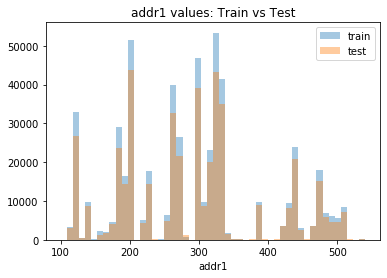

In [121]:

sns.distplot(train['addr1'], kde=False, rug=False, label = 'train')
sns.distplot(test['addr1'], kde=False, rug=False, label = 'test')
plt.title('addr1 values: Train vs Test')
plt.legend()
plt.show

**unique values**

In [180]:
# addr1 unique values
train_val_count = train['addr1'].value_counts()
test_val_count = test['addr1'].value_counts()

uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

print('# of unique value that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique value that only appears in the test set: {}.'.format(len(in_test_not_in_train)))

# of unique values in the training set: 332
# of unique values in the test set: 292
# of unique value that only appears in the training set: 149.
# of unique value that only appears in the test set: 109.


### addr2 

**Histogram plot**

<function matplotlib.pyplot.show(*args, **kw)>

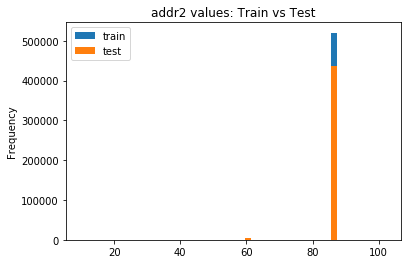

In [123]:
train['addr2'].plot(kind = 'hist',label = 'train', bins = 50,
                            title = 'addr2 values: Train vs Test')
test['addr2'].plot(kind = 'hist',label = 'test',bins = 50)
plt.legend()
plt.show

**unique values** 

In [183]:
# addr2 unique values
train_val_count = train['addr2'].value_counts()
test_val_count = test['addr2'].value_counts()

uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

print('# of unique value that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique value that only appears in the test set: {}.'.format(len(in_test_not_in_train)))

# of unique values in the training set: 74
# of unique values in the test set: 72
# of unique value that only appears in the training set: 21.
# of unique value that only appears in the test set: 19.


## M1 - M9 (cat)

In [33]:
col = ['M'+str(i) for i in range(1,10)]
train[col].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

### Missing values

In [35]:
pd.DataFrame(100*train[col].isna().sum()/train.shape[0]).sort_values(by = 0)

0
M6  28.678836
M1  45.907136
M2  45.907136
M3  45.907136
M4  47.658753
M8  58.633115
M9  58.633115
M7  58.635317
M5  59.349409

We can find groups of M columns that shared similar NAN structure.

### Histogram Plot

In [ ]:
dt = train[col].fillna('-999')
dtest = test[col].fillna('-999')

In [370]:
# function to make subplots
# input list of colunms names
def cat_sub_plots(col,test,trian):
    ncol = 3
    row = len(col)//3
    plt.figure(figsize=(14,row*4))
    
    for i,v in enumerate(col): 
        dictrain = dict(Counter(trian[v]))
        dtest = dict(Counter(test[v]))
        plt.subplot(row, ncol, i+1)
        plt.bar(dictrain.keys(),dictrain.values(),color = 'lightskyblue', label = 'train',alpha = 0.5)
        plt.bar(dtest.keys(),dtest.values(),color = 'wheat', label = 'test',alpha = 0.5)
        plt.legend()
        plt.title(v)
    plt.show()

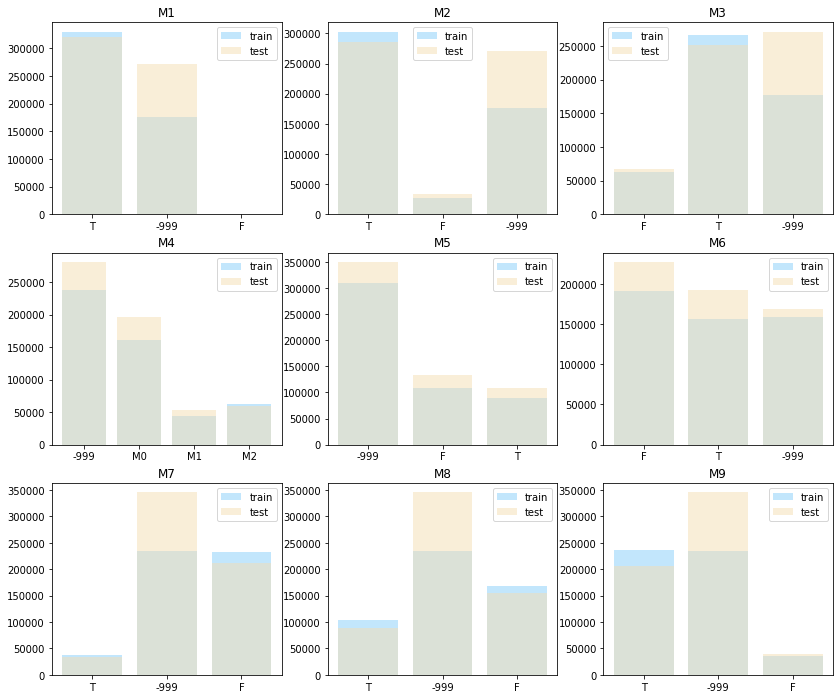

In [371]:
cat_sub_plots(col,dt,dtest)

### Unique values

In [167]:
for i in col:
    print(i +': ', Counter(train[i]))

M1:  Counter({'T': 319415, nan: 271100, 'F': 25})
M2:  Counter({'T': 285468, nan: 271100, 'F': 33972})
M3:  Counter({nan: 271100, 'T': 251731, 'F': 67709})
M4:  Counter({nan: 281444, 'M0': 196405, 'M2': 59865, 'M1': 52826})
M5:  Counter({nan: 350482, 'F': 132491, 'T': 107567})
M6:  Counter({'F': 227856, 'T': 193324, nan: 169360})
M7:  Counter({nan: 346265, 'F': 211374, 'T': 32901})
M8:  Counter({nan: 346252, 'F': 155251, 'T': 89037})
M9:  Counter({nan: 346252, 'T': 205656, 'F': 38632})


In [169]:
train_val_count = train['M1'].value_counts()
test_val_count = test['M1'].value_counts()

uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

print('# of unique value that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique value that only appears in the test set: {}.'.format(len(in_test_not_in_train)))

# of unique values in the training set: 2
# of unique values in the test set: 2
# of unique value that only appears in the training set: 0.
# of unique value that only appears in the test set: 0.


## dist1, dist2

In [106]:
train[['dist1', 'dist2']].head()

dist1  dist2
0   19.0    NaN
1    NaN    NaN
2  287.0    NaN
3    NaN    NaN
4    NaN    NaN

### Missing values

In [108]:
train[['dist1', 'dist2']].isna().sum()/train.shape[0]

dist1    0.596524
dist2    0.936284
dtype: float64

### dist1 

<function matplotlib.pyplot.show(*args, **kw)>

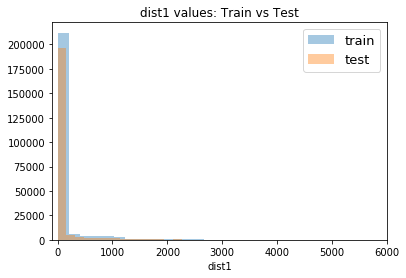

In [158]:
sns.distplot(train['dist1'], kde=False, rug=False, label = 'train')
sns.distplot(test['dist1'], kde=False, rug=False, label = 'test')
plt.title('dist1 values: Train vs Test')
plt.xlim(-100,6000)
plt.legend(fontsize = 13)
plt.show

### dist2 

<function matplotlib.pyplot.show(*args, **kw)>

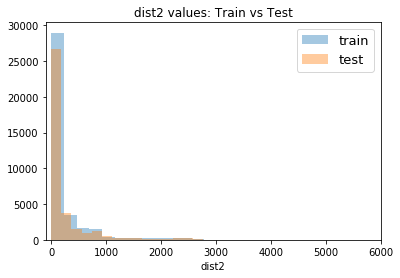

In [159]:
sns.distplot(train['dist2'], kde=False, rug=False, label = 'train')
sns.distplot(test['dist2'], kde=False, rug=False, label = 'test')
plt.title('dist2 values: Train vs Test')
plt.xlim(-100,6000)
plt.legend(fontsize = 13)
plt.show

## C1 - C14

In [176]:
col = ['C'+str(i) for i in range(1,15)]
train[col].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

### Missing values

In [76]:
100*train[['C'+str(i) for i in range(1,15)]].isna().sum()/train.shape[0]

C1     0.0
C2     0.0
C3     0.0
C4     0.0
C5     0.0
C6     0.0
C7     0.0
C8     0.0
C9     0.0
C10    0.0
C11    0.0
C12    0.0
C13    0.0
C14    0.0
dtype: float64

### Correlation 

In [ ]:
nan_df = train.isna()
nan_groups = {} # dictionary containing colunms with the same sum of nan
for c in cols:
    # sum of nan of each columns
    col_sum = nan_df[c].sum()
    if col_sum in nan_groups.keys():
        nan_groups[col_sum].append(c)
    else:
        nan_groups[col_sum] = [c]
del nan_df

<function matplotlib.pyplot.show(*args, **kw)>

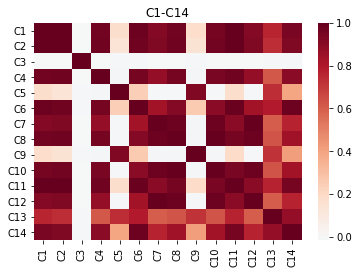

In [170]:
col = ['C'+str(i) for i in range(1,15)]
train2 = train[col].sample(frac = 0.2)
plt.figure()
cor = train2[col].corr()
sns.heatmap(cor, cmap = 'RdBu_r',annot=False, center=0.0)
plt.title('C1-C14')
plt.show

We can see that C columns are highly correlated.


In [261]:
print('C1')
d = cor['C1'].reindex(cor['C1'].abs().sort_values(ascending = False).index)
d

C1


C1     1.000000
C11    0.996430
C2     0.995115
C6     0.981704
C4     0.965719
C8     0.965591
C10    0.955525
C14    0.950627
C12    0.923415
C7     0.921655
C13    0.767190
C9     0.185038
C5     0.173652
C3    -0.003308
Name: C1, dtype: float64

```['C1', 'C11', 'C2', 'C6', 'C4', 'C8', 'C10', 'C14', 'C12', 'C7', 'C13']``` are highly correlated.

In [263]:
cor['C9'].reindex(cor['C9'].abs().sort_values(ascending = False).index)

C9     1.000000
C5     0.922933
C13    0.715147
C14    0.411117
C6     0.261924
C11    0.191607
C1     0.185038
C2     0.141670
C4    -0.015908
C10   -0.014553
C8    -0.014355
C7    -0.012167
C12   -0.011950
C3    -0.009728
Name: C9, dtype: float64

```[C9,C5]``` are highly correlated.

In [264]:
cor['C3'].reindex(cor['C3'].abs().sort_values(ascending = False).index)

C3     1.000000
C9    -0.009728
C5    -0.007827
C13   -0.007259
C14   -0.004778
C6    -0.004631
C11   -0.003494
C1    -0.003308
C2    -0.003244
C12   -0.001665
C7    -0.001636
C4    -0.001617
C10   -0.001366
C8    -0.001020
Name: C3, dtype: float64

C3 does not correlated with any C columns.

  
Thus, there are **3 groups** in C columns, which are ```[['C1', 'C11', 'C2', 'C6', 'C4', 'C8', 'C10', 'C14', 'C12', 'C7'],[C9,C5,C13],[C3]]```.


### Histogram Plot

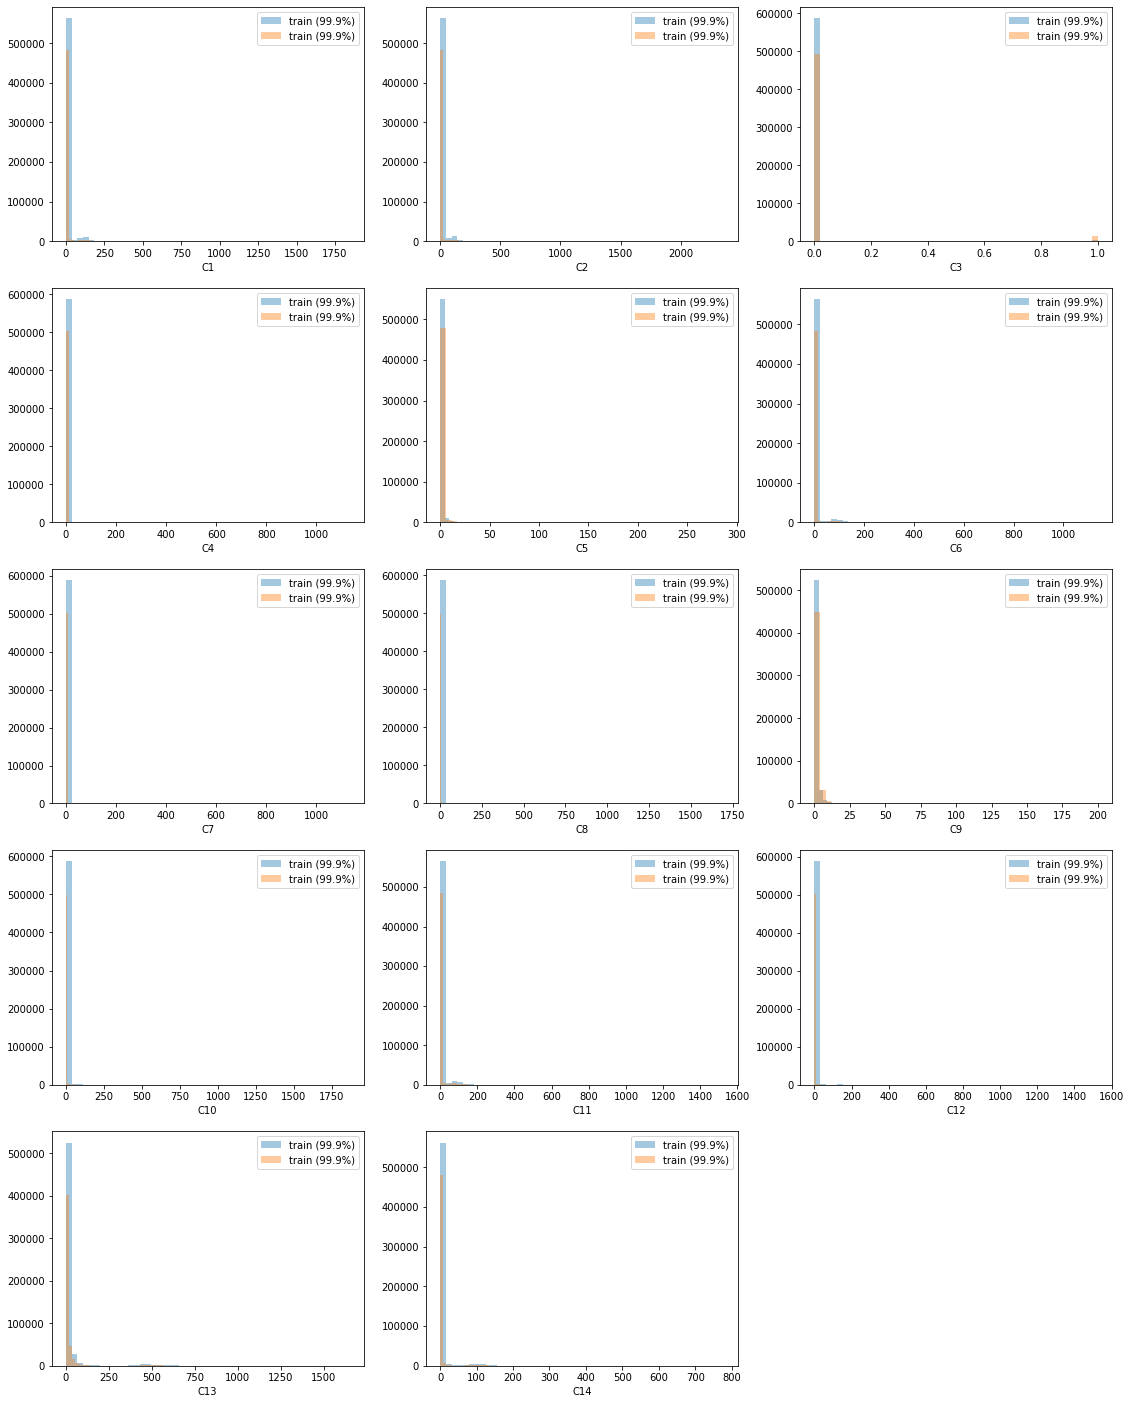

In [257]:
sub_plots(col)

We can see that test set contains some values that are not in the training set.

### C1

In [22]:
d1 = train[['C1','TransactionDT','isFraud']]
d2 = test[['C1','TransactionDT']]

**Distribution over time**

<function matplotlib.pyplot.show(*args, **kw)>

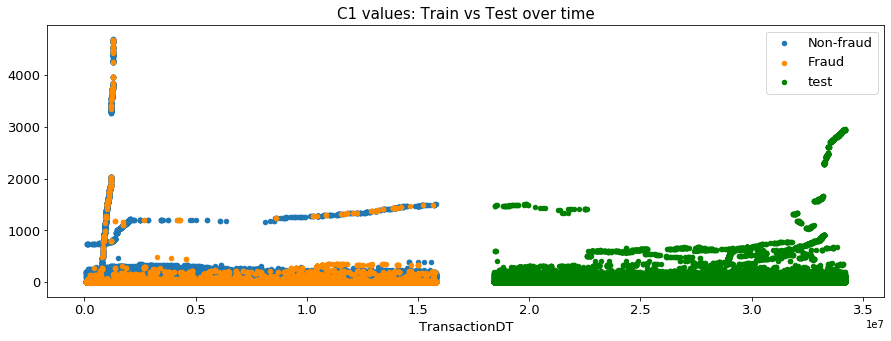

In [253]:
ax=d1.loc[d1['isFraud']==0,:].plot(kind = 'scatter',x ='TransactionDT' ,y='C1',label = 'Non-fraud',figsize=(15, 5),fontsize=15)
ax2=d1.loc[d1['isFraud']==1,:].plot(kind = 'scatter',x ='TransactionDT' ,y='C1',label = 'Fraud',figsize=(15, 5)
                            ,ax=ax,color='darkorange',fontsize=13)
ax3=d2.plot(kind = 'scatter',x ='TransactionDT' ,y='C1',label = 'test',ax=ax,color='green',fontsize=13)
plt.legend(fontsize=13)
plt.xlabel('TransactionDT',fontsize=13)
plt.ylabel('')
plt.title('C1 values: Train vs Test over time',fontsize=15)
plt.show


**Unique values**

In [52]:
# addr2 unique values
train_val_count = train['C1'].value_counts()
test_val_count = test['C1'].value_counts()

uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

print('# of unique value that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique value that only appears in the test set: {}.'.format(len(in_test_not_in_train)))

# of unique values in the training set: 1657
# of unique values in the test set: 1174
# of unique value that only appears in the training set: 1013.
# of unique value that only appears in the test set: 530.


We can see that test set contains some values that are not in the training set.

## id_01 - id_38

id_12 - id_38 are categorical variables

In [145]:
col = ['id_0'+str(i) for i in range(1,10)]+['id_'+str(i) for i in range(10,39)]

### Missing values

In [41]:
pd.DataFrame(100*train[col].isna().sum()/train.shape[0]).sort_values(by = 0)

0
id_01  75.576083
id_12  75.576083
id_36  76.126088
id_35  76.126088
id_37  76.126088
id_15  76.126088
id_38  76.126088
id_29  76.127273
id_11  76.127273
id_28  76.127273
id_02  76.145223
id_31  76.245132
id_17  76.399736
id_19  76.408372
id_20  76.418024
id_05  76.823755
id_06  76.823755
id_16  78.098012
id_13  78.440072
id_14  86.445626
id_34  86.824771
id_32  86.861855
id_30  86.865411
id_10  87.312290
id_09  87.312290
id_33  87.589494
id_04  88.768923
id_03  88.768923
id_18  92.360721
id_23  99.124699
id_22  99.124699
id_27  99.124699
id_26  99.125715
id_21  99.126393
id_07  99.127070
id_08  99.127070
id_25  99.130965
id_24  99.196159

In [12]:
d = pd.DataFrame(100*train[col].isna().sum()/train.shape[0]).sort_values(by = 0)

we can see that lots of id values are missing.

### Unique values

In [316]:
print('Top 10 unique values in the training set')
for i in col:
    print(i, list(train[i].value_counts().index)[:10])

Top 10 unique values in the training set
id_01 [-5.0, 0.0, -10.0, -20.0, -15.0, -25.0, -45.0, -35.0, -40.0, -100.0]
id_02 [1102.0, 696.0, 1141.0, 1083.0, 1116.0, 1120.0, 1117.0, 1127.0, 1138.0, 1166.0]
id_03 [0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, -5.0, -6.0, -4.0]
id_04 [0.0, -5.0, -6.0, -8.0, -4.0, -1.0, -11.0, -12.0, -10.0, -9.0]
id_05 [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 5.0, 7.0, 8.0, 9.0]
id_06 [0.0, -1.0, -5.0, -6.0, -9.0, -100.0, -8.0, -10.0, -11.0, -7.0]
id_07 [0.0, 16.0, 14.0, 12.0, 15.0, 17.0, 4.0, 13.0, 5.0, 10.0]
id_08 [-100.0, 0.0, -34.0, -33.0, -32.0, -35.0, -25.0, -31.0, -30.0, -24.0]
id_09 [0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, -6.0, -5.0, -4.0]
id_10 [0.0, -6.0, -5.0, -1.0, -8.0, -11.0, -9.0, -12.0, -10.0, -7.0]
id_11 [100.0, 95.08000183105469, 95.16000366210938, 97.12000274658205, 96.66999816894531, 95.6500015258789, 96.19000244140624, 94.29000091552734, 93.5500030517578, 96.47000122070312]
id_12 ['NotFound', 'Found']
id_13 [52.0, 49.0, 64.0, 33.0, 27.0, 20.0, 14.0, 63.0, 19.0, 2

In [302]:
train_val_count = train['id_01'].value_counts()
test_val_count = test['id-01'].value_counts()

uniq_train = set(train_val_count.index)
uniq_test = set(test_val_count.index)
in_train_not_in_test = uniq_train - uniq_test
in_test_not_in_train = uniq_test - uniq_train

print('# of unique values in the training set:',len(train_val_count))
print('# of unique values in the test set:',len(test_val_count))

print('# of unique value that only appears in the training set: {}.'.format(len(in_train_not_in_test)))
print('# of unique value that only appears in the test set: {}.'.format(len(in_test_not_in_train)))

# of unique values in the training set: 77
# of unique values in the test set: 80
# of unique value that only appears in the training set: 9.
# of unique value that only appears in the test set: 12.


### Histogram Plot

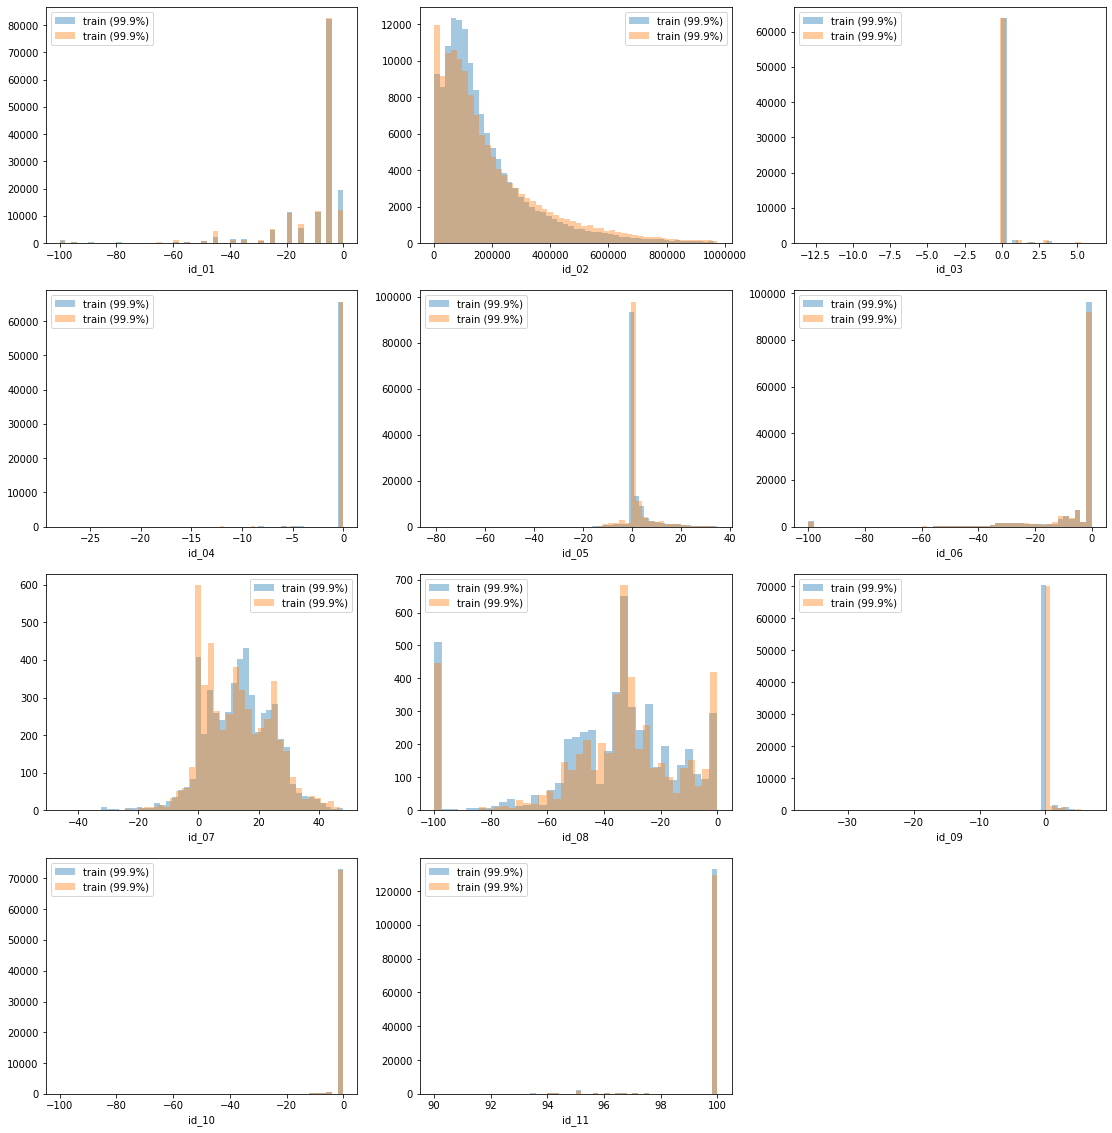

In [346]:
sub_plots(col[:11])

## DeviceInfo & DeviceType

### Missing values

In [43]:
100*train['DeviceType'].isna().sum()/train.shape[0]

76.15572188166763

In [44]:
100*train['DeviceInfo'].isna().sum()/train.shape[0]

79.90551021099333

### Unique values

In [73]:
print('DeviceType')
print('Train', pd.DataFrame(train['DeviceType'].value_counts()))

print('Test', pd.DataFrame(test['DeviceType'].value_counts()))

DeviceType
Train          DeviceType
desktop       85165
mobile        55645
Test          DeviceType
desktop       74403
mobile        62528


In [77]:
print('DeviceInfo')
print('Train', pd.DataFrame(train['DeviceInfo'].value_counts()))
print('Test', pd.DataFrame(test['DeviceInfo'].value_counts()))

DeviceInfo
Train                   DeviceInfo
Windows                47722
iOS Device             19782
MacOS                  12573
Trident/7.0             7440
rv:11.0                 1901
...                      ...
SM-T817T                   1
Minion_Tab                 1
NXA116QC164                1
SPH-L720                   1
SAMSUNG-SM-T807A           1

[1786 rows x 1 columns]
Test                                    DeviceInfo
Windows                                 44988
iOS Device                              18720
MacOS                                   11149
Trident/7.0                              4890
rv:11.0                                   749
...                                       ...
SM-T230 Build/KOT49H                        1
Moto E (4) Build/NDQS26.69-23-2-3           1
VFD                                         1
SAMSUNG-SM-G890A Build/MMB29K               1
vivo                                        1

[2226 rows x 1 columns]


# Data Cleaning

## Split X, y

In [10]:
y_train = train['isFraud']

(590540, 433)
(506691, 433)


In [36]:
X_train = train.drop(['isFraud'],axis = 1)

In [ ]:
X_test = test

In [37]:
print(X_train.shape)
print(X_test.shape)

(590540, 433)
(506691, 93)


In [35]:
# drop TransactionID
X_train.drop('TransactionID', axis = 1, inplace = True)

In [ ]:
X_test.drop('TransactionID', axis = 1, inplace = True)

print(X_train.shape)
print(X_test.shape)

## Mapping Emails

In [12]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo','servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

In [13]:
for c in ['P_emaildomain', 'R_emaildomain']:
    X_train[c + '_bin'] = train[c].map(emails)
    X_test[c + '_bin'] = test[c].map(emails)

In [31]:
X_train.drop(['P_emaildomain', 'R_emaildomain'] , axis=1, inplace=True)

In [33]:
print(X_train.shape)
print(X_test.shape)

(590540, 93)
(506691, 93)


In [32]:
X_test.drop(['P_emaildomain', 'R_emaildomain'] , axis=1, inplace=True)

print(X_train.shape)
print(X_test.shape)

KeyError: "['P_emaildomain' 'R_emaildomain'] not found in axis"

In [19]:
X_train['P_emaildomain_bin'].value_counts()

google         228851
yahoo          109149
microsoft       59477
other           52868
aol             28604
apple            8225
att              7210
spectrum         1046
centurylink       654
Name: P_emaildomain_bin, dtype: int64

# Feature Selection

## PCA：V1 -  V339

In [19]:
Vcols = ['V'+str(x) for x in range(1,340)]
train[Vcols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

### Correlation

<function matplotlib.pyplot.show(*args, **kw)>

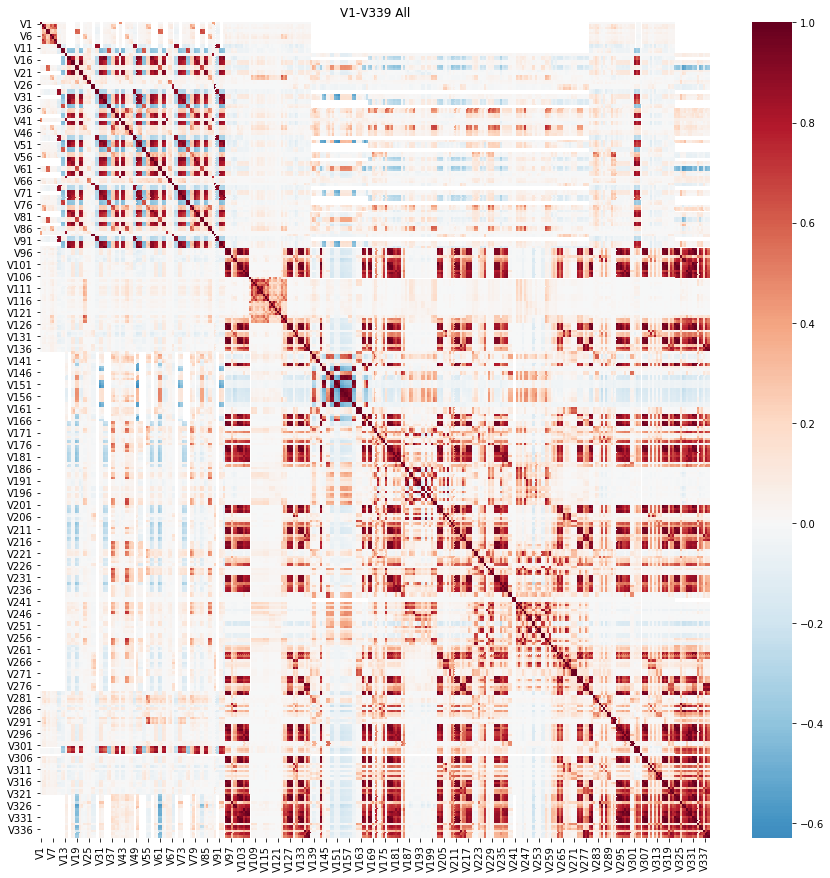

In [109]:
train2 = train[Vcols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[Vcols].corr(), cmap = 'RdBu_r',annot=False, center=0.0)
plt.title('V1-V339 All')
plt.show

We can see that the first 100 Vs correlated with each other while the last 239 Vs correlated with each other.

Notice that V columns appear to be highly redundant and correlated. 

### Similar NAN structure

In [110]:
100*train[['V'+str(i) for i in range(1,340)]].isna().sum()/train.shape[0]


V1      47.293494
V2      47.293494
V3      47.293494
V4      47.293494
V5      47.293494
          ...    
V335    86.054967
V336    86.054967
V337    86.054967
V338    86.054967
V339    86.054967
Length: 339, dtype: float64

 We can find groups of V columns that shared similar NAN structure.

In [111]:
nan_df = train.isna()
nan_groups = {} # dictionary containing colunms with the same sum of nan
for c in Vcols:
    # sum of nan of each columns
    col_sum = nan_df[c].sum()
    if col_sum in nan_groups.keys():
        nan_groups[col_sum].append(c)
    else:
        nan_groups[col_sum] = [c]
del nan_df



In [112]:
print('There are ' + str(len(list(nan_groups.keys())))+ ' groups.')

There are 15 groups.


In [113]:
for key,value in nan_groups.items():
    print('NAN count',key)
    print(value)

NAN count 279287
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
NAN count 76073
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
NAN count 168969
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
NAN count 77096
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
NAN count 89164
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
NAN count 314
['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126'

### Hitogram Plot

In [118]:
ind = list(nan_groups.keys())[0]

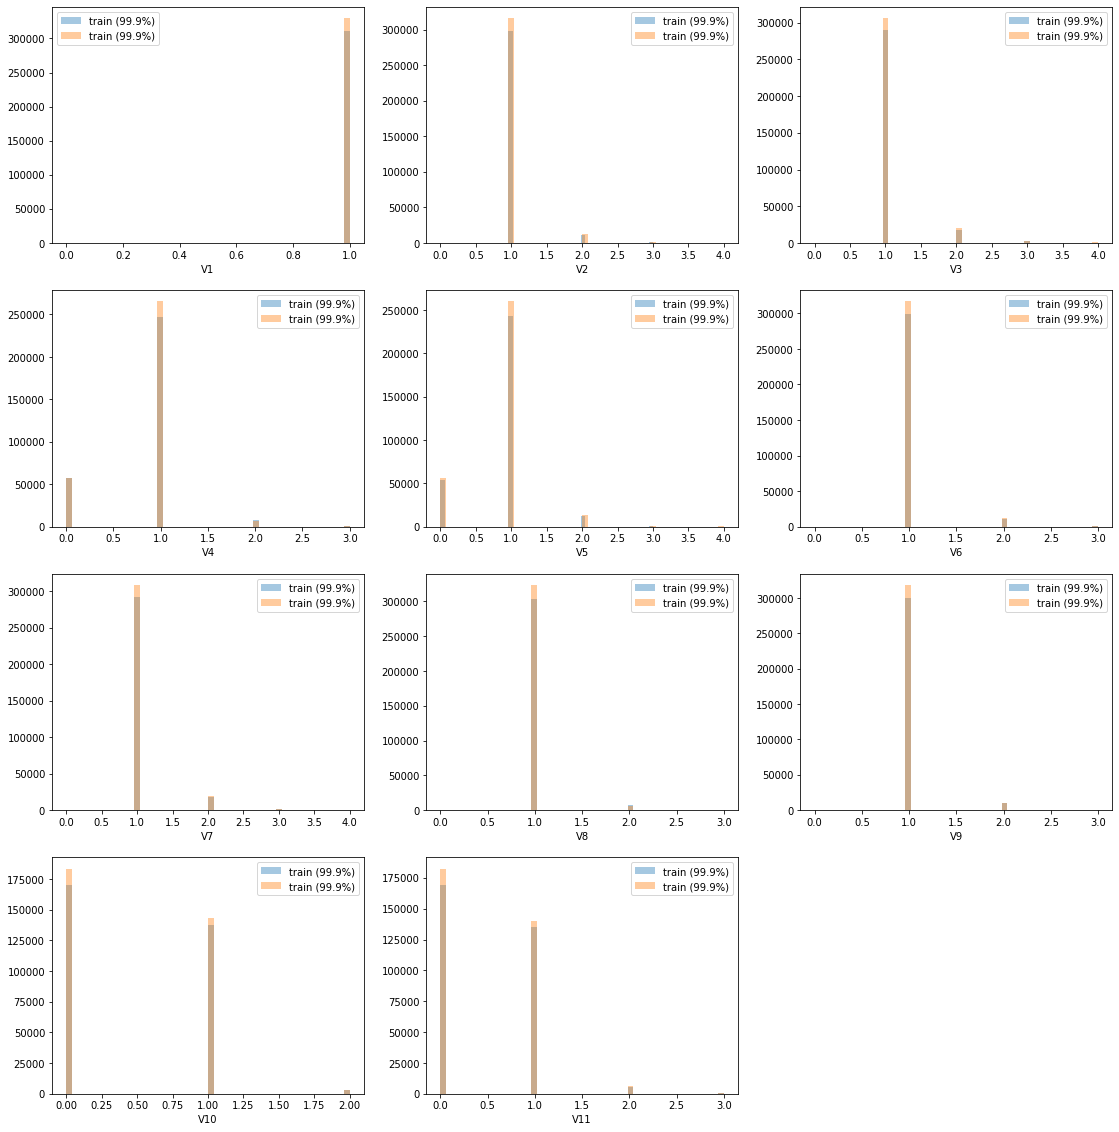

In [119]:
# look at the distribution for each group
sub_plots(nan_groups[ind]) # function to make subplots

### Method 1: Subset grouped by correlation

 **group1:** ```['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']```

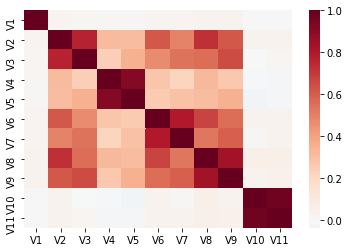

In [120]:
sns.heatmap(train[nan_groups[ind]].corr(),cmap = 'RdBu_r',annot=False,center=0.0)

In [121]:
corr_group1 = train[nan_groups[ind]].corr()
corr_group1

V1        V2        V3        V4        V5        V6        V7  \
V1   1.000000  0.032168  0.024830  0.014216  0.013619  0.032284  0.026016   
V2   0.032168  1.000000  0.773039  0.318554  0.305504  0.621459  0.496921   
V3   0.024830  0.773039  1.000000  0.243684  0.353767  0.472570  0.546875   
V4   0.014216  0.318554  0.243684  1.000000  0.915164  0.279596  0.221621   
V5   0.013619  0.305504  0.353767  0.915164  1.000000  0.261490  0.294447   
V6   0.032284  0.621459  0.472570  0.279596  0.261490  1.000000  0.796027   
V7   0.026016  0.496921  0.546875  0.221621  0.294447  0.796027  1.000000   
V8   0.040820  0.732730  0.556536  0.325873  0.308716  0.675501  0.538586   
V9   0.034009  0.618591  0.653087  0.273207  0.354257  0.561332  0.594988   
V10  0.006574  0.036884 -0.005272 -0.013160 -0.035405  0.040767  0.014593   
V11  0.006408  0.037459  0.022911 -0.016662 -0.021949  0.038673  0.039807   

           V8        V9       V10       V11  
V1   0.040820  0.034009  0.006574  0.006408  
V2   0.732730  0.618591  0.036884  0.037459  
V3   0.556536  0.653087 -0.005272  0.022911  
V4   0.325873  0.273207 -0.013160 -0.016662  
V5   0.308716  0.354257 -0.035405 -0.021949  
V6   0.675501  0.561332  0.040767  0.038673  
V7   0.538586  0.594988  0.014593  0.039807  
V8   1.000000  0.835342  0.061869  0.058033  
V9   0.835342  1.000000  0.034524  0.055620  
V10  0.061869  0.034524  1.000000  0.968670  
V11  0.058033  0.055620  0.968670  1.000000

We can further group this group by correlation ```[[1],[2,3],[4,5],[6,7],[8,9],[10,11]]```. Thus we can replace V1 - V11 with ```[1, 3, 4, 6, 8, 11]```.

### Methond 2: PCA

In [143]:
pca_train.head()

V1        V2        V3        V4        V5        V6        V7  \
0  1.000000  0.125000  0.111111  0.166667  0.166667  0.111111  0.111111   
1  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   
2  1.000000  0.125000  0.111111  0.166667  0.166667  0.111111  0.111111   
3  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   
4  0.999945  0.130651  0.119786  0.141076  0.146165  0.116187  0.119208   

         V8        V9       V10  ...      V330      V331      V332      V333  \
0  0.125000  0.125000  0.000000  ...  0.014107  0.004511  0.008599  0.006341   
1  0.128463  0.130191  0.115979  ...  0.014107  0.004511  0.008599  0.006341   
2  0.125000  0.125000  0.000000  ...  0.014107  0.004511  0.008599  0.006341   
3  0.128463  0.130191  0.115979  ...  0.014107  0.004511  0.008599  0.006341   
4  0.128463  0.130191  0.115979  ...  0.000000  0.000000  0.000000  0.000000   

       V334      V335      V336      V337      V338      V339  
0  0.000178  0.001073  0.000518  0.000532  0.001453  0.000968  
1  0.000178  0.001073  0.000518  0.000532  0.001453  0.000968  
2  0.000178  0.001073  0.000518  0.000532  0.001453  0.000968  
3  0.000178  0.001073  0.000518  0.000532  0.001453  0.000968  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[5 rows x 339 columns]

In [124]:
# mean impute
pca_train = pd.DataFrame(train[Vcols].fillna(train[Vcols].mean()))
pca_test = pd.DataFrame(test[Vcols].fillna(train[Vcols].mean()))

In [126]:
# standardilize
scaler = MinMaxScaler()
pca_train = scaler.fit_transform(pca_train)
pca_test =  scaler.transform(pca_test)

In [139]:
pca_train = pd.DataFrame(pca_train)
pca_test = pd.DataFrame(pca_test)

In [141]:
pca_train.columns = ['V'+str(i) for i in range(1,340)]
pca_test.columns = ['V'+str(i) for i in range(1,340)]

In [145]:
# pca 
# select the number of components such that more than 95% of variance is explained.
pca = PCA(n_components = 0.95)

# Dataframe stores pca
reduced_train_Vs = pd.DataFrame(train['V1'])
reduced_test_Vs = pd.DataFrame(test['V1'])

for i in list(nan_groups.keys()):
    # get each group
    train_sub = pca_train[nan_groups[i]]
    test_sub = pca_test[nan_groups[i]]
    
    # get pca for each group
    train_compon= pca.fit_transform(train_sub)
    # store as dataframe
    train_compon = pd.DataFrame(train_compon)
    # merger to pca dataframe
    reduced_train_Vs = reduced_train_Vs.merge(train_compon,left_index=True,right_index=True)
    
    # get pca for test set
    test_compon= pca.transform(test_sub)
    # store as dataframe
    test_compon = pd.DataFrame(test_compon)
    # merge to pca dataframe(test)
    reduced_test_Vs = reduced_test_Vs.merge(train_compon,left_index=True,right_index=True)  

In [146]:
#reduced_train_Vs.to_csv('/Users/chenxian/Desktop/ieee-fraud-detection/train_reduced_V.csv')
#reduced_test_Vs.to_csv('/Users/chenxian/Desktop/ieee-fraud-detection/test_reduced_V.csv')

In [15]:
reduced_train_Vs = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/train_reduced_V.csv')
reduced_test_Vs = pd.read_csv('/Users/chenxian/Desktop/ieee-fraud-detection/test_reduced_V.csv')

In [16]:
# drop unrelevent columns
reduced_train_Vs = reduced_train_Vs.drop(['V1','Unnamed: 0'],axis = 1)
reduced_test_Vs = reduced_test_Vs.drop(['V1','Unnamed: 0'],axis = 1)

In [17]:
reduced_train_Vs.columns = ['PC'+str(i+1) for i in range(len(reduced_train_Vs.columns))]
reduced_test_Vs.columns = ['PC'+str(i+1) for i in range(len(reduced_test_Vs.columns))]

In [20]:
print('Original set has '+str(len(Vcols))+ ' V columns.')
print('Reduced training set has '+str(reduced_train_Vs.shape[1])+ ' V columns.')
print('Reduced testing set has '+str(reduced_train_Vs.shape[1])+ ' V columns.')

Original set has 339 V columns.
Reduced training set has 93 V columns.
Reduced testing set has 93 V columns.


<function matplotlib.pyplot.show(*args, **kw)>

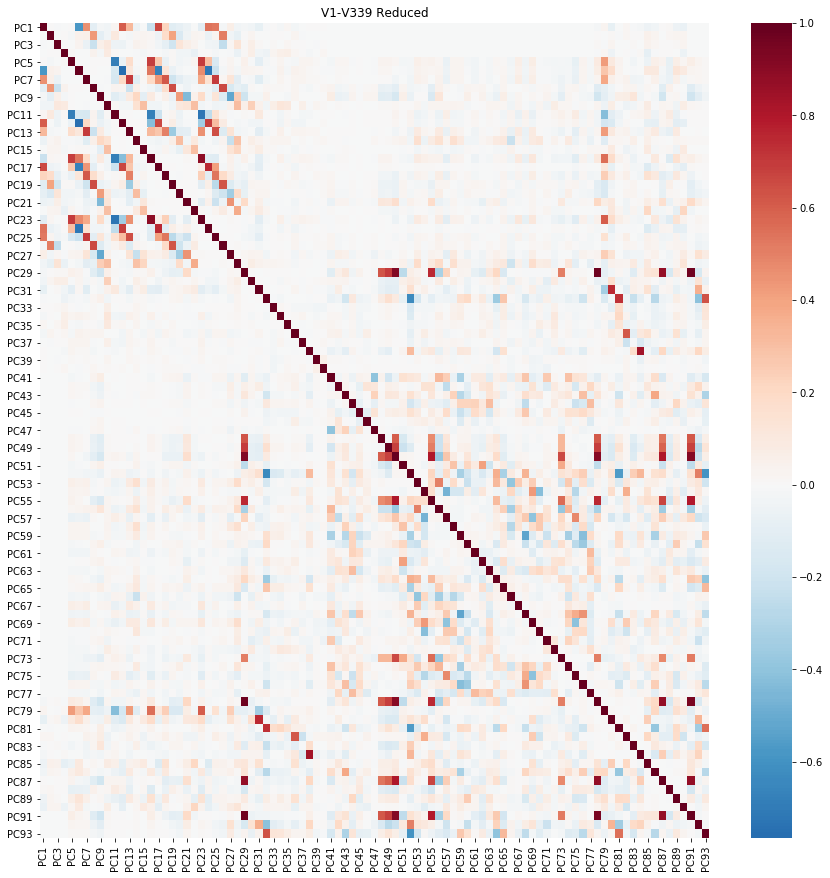

In [154]:
train_red = reduced_train_Vs.sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train_red.corr(), cmap = 'RdBu_r',annot=False, center=0.0)
plt.title('V1-V339 Reduced')
plt.show

 We can see that the reduced set has less internal correlation.

In [21]:
# drop  V columns
X_train = train.drop(Vcols,axis = 1)
X_test = test.drop(Vcols,axis = 1)

print(X_train.shape)
print(X_test.shape)

(590540, 95)
(506691, 93)


In [ ]:
list(X_train.columns)  list(X_test.columns)

In [26]:
set(X_train.columns) - set(X_test.columns)

{'P_emaildomain', 'R_emaildomain', 'TransactionID', 'isFraud'}

In [27]:
X_train['R_emaildomain']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
590535    NaN
590536    NaN
590537    NaN
590538    NaN
590539    NaN
Name: R_emaildomain, Length: 590540, dtype: object

In [25]:
# Concatenate PCA components
X_train=pd.concat([X_train, reduced_train_Vs], axis=1)
X_test = pd.concat([X_test, reduced_test_Vs], axis=1)

print(X_train.shape)
print(X_test.shape)

(590540, 188)
(506691, 186)


In [29]:
set(X_train.columns) - set( X_test.columns)

{'P_emaildomain', 'R_emaildomain', 'TransactionID', 'isFraud'}

## Adversarial Validation
From EDA, we found that the training set contains some cards that are not included in the test set, and the test set also contains some cards that have not been seen in the training set. We can find features that are important in differentiating cards by performing adversarial validation using data with PCA columns.   

In [1]:
st = list(X_train.columns).index("V1")
ed = list(X_train.columns).index("V339")
print(st)
print(ed)

print(list(X_test.columns).index("V1"))
print(list(X_test.columns).index("V339"))


NameError: name 'X_train' is not defined

In [124]:
# step 1: set label

X_train['is_test'] = 0
X_test['is_test'] = 1

In [20]:
# step 2: concatenate both frames and shuffle the rows

data = pd.concat([X_train.iloc[,[:st]+[ed+1:]], X_test.iloc[,[:st]+[ed+1:]]])

#replace nan with -999
data.fillna(-999,inplace=True)

In [125]:
X_train.drop('is_test',axis = 1, inplace = True)
X_test.drop('is_test',axis = 1, inplace = True)

In [21]:
seed = 2020

In [24]:
#split X, y
y_adv = data['is_test']
x_adv = data.drop(['is_test'], axis = 1)

x_adv_train, x_adv_test, y_adv_train, y_adv_test = train_test_split(x_adv, y_adv, 
                                                                    train_size = 0.3,random_state = seed)


In [ ]:
for i in range(1,16):
    x_adv_train['D'+str(i)+'n'] = x_adv_train['D'+str(i)] - x_adv_train['TransactionDT']/(24*60*60)
    x_adv_test['D'+str(i)+'n'] = x_adv_test['D'+str(i)] -x_adv_testtest['TransactionDT']/(24*60*60)

In [25]:
cat_cols = []
for i in X_test.columns:
    if X_test[i].dtype =='object' or X_train[i].dtype == 'object' :
        cat_cols.append(i)

### model 1

In [26]:
train_data = Pool(
    data=x_adv_train,
    label=y_adv_train,
    cat_features=cat_cols,
)
holdout_data = Pool(
    data=x_adv_test,
    label=y_adv_test,
    cat_features=cat_cols,
)

In [27]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'verbose': False,
    'random_seed': seed
}

cat_adv = CatBoostClassifier(**params)
cat_adv.fit(train_data, eval_set=holdout_data)

In [32]:
cat_adv.best_score_

Accuracy on training data:  0.9999392409370262
Accuracy on test data:  0.9998880298725884


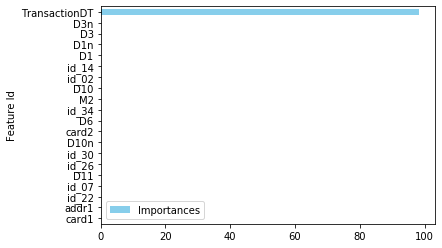

In [29]:
feature_score = cat_adv.get_feature_importance(prettified=True)
feature_score[:20].sort_values('Importances').plot(
    'Feature Id', 'Importances', kind='barh', color='skyblue')

### model 2

In [30]:
# remove version

def remove_version(train, test, feature):
    train.loc[:, feature] = train[feature].str.replace(r'[^A-Za-z]', '', regex=True)
    test.loc[:, feature] = test[feature].str.replace(r'[^A-Za-z]', '', regex=True)
    
remove_version(x_adv_train,x_adv_test,'id_31')
remove_version(x_adv_train,x_adv_test,'id_30')


/Users/chenxian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
# ignore TransactionDT

params2 = dict(params)
params2.update({"ignored_features": ['TransactionDT']},)


In [46]:
cat_adv2 = CatBoostClassifier(**params2)
cat_adv2.fit(train_data, eval_set=holdout_data)

In [54]:
cat_adv2.best_score_

{'learn': {'Logloss': 0.0011556733529831163},
 'validation': {'Logloss': 0.0014197234288285995, 'AUC': 0.9999994920788481}}

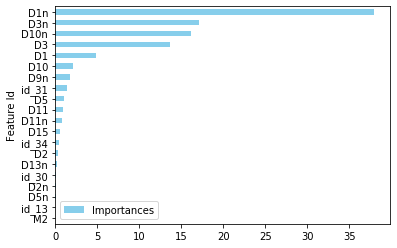

In [48]:
feature_score = cat_adv2.get_feature_importance(prettified=True)
feature_score[:20].sort_values('Importances').plot(
    'Feature Id', 'Importances', kind='barh', color='skyblue')

We can see that ```['D1n','D3n','D10n','D9n','D5','D11','D15','D2','D13n']``` are very important to identify card users.

### model 3

In [62]:
params3 = dict(params2)
params3.update({"ignored_features": ['TransactionDT']+['D'+str(i)+'n' for i in range(1,16)]},)

In [64]:
cat_adv3 = CatBoostClassifier(**params4)
cat_adv3.fit(train_data, eval_set=holdout_data)

In [65]:
cat_adv3.best_score_

{'learn': {'Logloss': 0.36947305202863634},
 'validation': {'Logloss': 0.37489074603426936, 'AUC': 0.9017605941771863}}

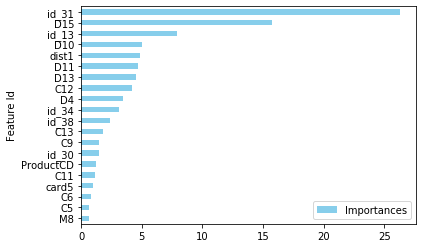

In [66]:
feature_score = cat_adv3.get_feature_importance(prettified=True)
feature_score[:20].sort_values('Importances').plot(
    'Feature Id', 'Importances', kind='barh', color='skyblue')

In [74]:
print('baseline: AUC =',cat_adv.best_score_['validation']['AUC'])
print('Removing TransactionDT&Version: AUC =',cat_adv2.best_score_['validation']['AUC'])
print('Removing Normalized D columns: AUC =',cat_adv3.best_score_['validation']['AUC'])

baseline: AUC = 0.9999999812094551
Removing TransactionDT&Version: AUC = 0.9999994920788481
Removing Normalized D columns: AUC = 0.9017605941771863


Overall, we can see that normalized D columns are very important in differentiating training data and test data. TransactionDT and version should be removed

## Remove software version

id_30 and id_31 contain software version. The data is collect by time. Version is related to time, indicating that test set contains version that have not been seen in the training set. Thus, we should remove version.

In [127]:
remove_version(X_train, X_test, 'id_31')
remove_version(X_train, X_test, 'id_30')

In [76]:
for i in ['id_30','id_31']:
    print(i, X_train[i].value_counts().index[:10])

id_30 Index(['Windows', 'iOS', 'MacOSX', 'Android', 'Linux', 'Mac', 'WindowsVista',
       'WindowsXP', 'other', 'func'],
      dtype='object')
id_31 Index(['chrome', 'chromeforandroid', 'mobilesafari', 'mobilesafarigeneric',
       'iefordesktop', 'safarigeneric', 'firefox', 'edge', 'chromegeneric',
       'samsungbrowser'],
      dtype='object')


## Remove TransactionDT

TransactionDT is timedelta from the transaction day, therefore the test set contain transactionDT that has not been seen in the training set.

In [128]:
X_train.drop('TransactionDT', axis=1, inplace=True)
X_test.drop('TransactionDT', axis=1, inplace=True)

## Normalize D columns

D columns are timedelta from a given reference datetime.
Transform the D columns into their points in the past by ```D15n = Transaction_Day - D15``` and ```Transaction_Day = TransactionDT/(24*60*60). ```
The normalized D columns are specified time in the past that something happend.


In [ ]:
# remove cols with nan% > 87% 
X_train.drop(['D6','D7','D8','D9','D12','D14','D13'], axis = 1, inplace = True)
X_test.drop(['D6','D7','D8','D9','D12','D14','D13'], axis = 1, inplace = True)

In [133]:
# most important cols:['D1n','D3n','D10n','D5','D11','D15','D2','D4n']

for col in range(1,16):
    if col in [5,11,2]: 
        continue
    else:
        X_train['D'+str(i)+n] = X_train['D'+str(i)] - X_train['TransactionDT']/(24*3600)
        X_train['D'+str(i)+n] = X_test['D'+str(i)] - X_test['TransactionDT']/(24*3600)
        

# Feature Engineering

## Combining - uid

In [100]:
def fe_CB(col1, col2, df1, df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    print(nm, ', ', end = '')

## Frequency Encoding 


In [101]:
def fe_FE(cols,df1,df2):
    for col in cols:
        freq_map1 = df1[col].value_counts(normalize = True).to_dict()
        freq_map2 = df2[col].value_counts(normalize = True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(freq_map1)
        df2[nm] = df2[col].map(freq_map2)
        print(nm, ', ', end = '')

In [12]:
# replace all frequency encoded features' values that appear less than 0.1% with a new value

def fe_FE_rare(cols,df1,df2):
    for col in cols:
        df1[col][df1[col] < 0.001] = -888
        df2[col][df2[col] < 0.001] = -888


## Aggregations / Group Statistics 


In [102]:
def fe_AG(uids, t_cols, aggregations, df1,df2, usena = False):
    '''
    GROUP AGGREGATION mean, std
    '''
    for col in t_cols:
        for i in uids:
            for agg_tpye in aggregations:
                new_col_name = col+'_'+i+'_'+agg_tpye
                
                temp_df_train = df1[[col,i]]
                temp_df_test = df2[[col,i]]
                
                if usena:
                    temp_df_train.fillna(np.nan)
                    temp_df_test.fillna(np.nan)
                
                #group by uid, get mean of col for each uid
                map1 = temp_df_train.groupby(i)[col].agg(agg_tpye).to_dict()
                map2 = temp_df_test.groupby(i)[col].agg(agg_tpye).to_dict()
                
                df1[new_col_name] = df1[i].mapp(map1).astype('float32')
                df2[new_col_name]  = df2[i].map(map2).astype('float32')
                
                print(new_col_name,', ',end = '')


In [103]:
def ef_AG2(uids, t_cols, df1, df2):
    '''
    GROUP AGGREGATION nunique
    '''
    for col in t_cols:
        for i in uids:
            temp_df1 = df1[[col,i]]
            temp_df2 = df2[[col,i]]
            
            # group by uid, get # of distinct value of col for each group
            # set uid as index, to_dict then index will be key
            mp1 = temp_df1.groupby(i)[col].agg('nunique').to_dict()
            mp2 = temp_df2.groupby(i)[col].agg('nunique').to_dict()
            
            nm = col+'_'+i+'_'+agg_tpye
            
            df1[nm] = df1[i].map(mp1).astype('float32')
            df2[nm] = df2[i].map(mp2).astype('float32')
            
            print(nm,', ',end = '')
            
    

## NAN processing 


In [ ]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Fitting Data

In [ ]:
# Categorical Features 
cat_cols = []
for i in X_train.columns:
    if X_train[i].dtype=='object' or X_test[i].dtype=='object':
        cat_cols.append(i)        

## CatBoost

## xgboost

In [ ]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))        

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=209)

%%time
h = clf.fit(x_adv_train, y_adv_train, 
        eval_set=[(x_adv_train,y_adv_train)],
        verbose=50, early_stopping_rounds=100)


importances = pd.DataFrame.from_dict(clf.get_booster().get_score(importance_type="gain"),orient='index',
                                     columns=['importance'])
importances['feature'] = importances.index

sns.barplot(x="importance", y="feature", data=importances.sort_values(by="importance", ascending=False))
plt.title('Most Important Features')
plt.tight_layout()


# make prediction
y_pred = clf.predict_proba(x_adv_test)[:,1]
# acc
print('ROC AUC {}'.format(roc_auc_score(y_adv_test, y_pred)))

In [ ]:

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )

h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
            eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
            verbose=50, early_stopping_rounds=100)

# Validation Strategy
